In [1]:
# https://www.kaggle.com/code/hengck23/ver-1-demo-workflow-2-stage-approach
# Adaptation to my pipeline

In [2]:
%%script false --no-raise-error

'''
This is a demo workflow. It has following the limitations:

1. We use only sagittal_t2 and axial_t2. 
   Future version will use sagittal_t1.

2. We assume each view (sagittal_t2, axial_t2) has only one series_id.
   Future version will allow multiple series_id.
 
3. the level assignent to axial slices is still under experiment. 
'''

In [3]:
try:
    import natsort
except:
    !pip install '/kaggle/input/hengck23-ver-1-demo-workflow-2-stage-approach/natsort-8.4.0-py3-none-any.whl'


Processing /kaggle/input/hengck23-ver-1-demo-workflow-2-stage-approach/natsort-8.4.0-py3-none-any.whl


In [4]:
import sys, os
sys.path.append('/kaggle/input/hengck23-ver-1-demo-workflow-2-stage-approach')

from _dir_setting_ import *
print('NOT_KAGGLE:', NOT_KAGGLE)
print('DATA_KAGGLE_DIR:', DATA_KAGGLE_DIR)


import matplotlib
import matplotlib.pyplot as plt

from helper import *
from data import *

import torch.nn as nn
import torch

print('import ok!')

NOT_KAGGLE: False
DATA_KAGGLE_DIR: /kaggle/input/rsna-2024-lumbar-spine-degenerative-classification
import ok!


In [5]:
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 18.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=21bc65075e5289a0d1dd293c7d793aae6a778d615121611477ec0a8f8e1849a6
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=ac5827f73946452baa892caee477db779cbdd951617cc8750d9a03a54aeed9bd
  Stored in directory: /root/.cache/pip/wheels/35/cb/

In [6]:
PATCH_SIZE = 512

In [7]:
# STEP0 : SETUP DATA ==========================

cfg=dotdict(
    point_net=dotdict(
        checkpoint='/kaggle/input/rsna2024-demo-workflow/00002484.pth',
        image_size=PATCH_SIZE,
    ),
)

level_to_label={
    'l1_l2':1,
    'l2_l3':2,
    'l3_l4':3,
    'l4_l5':4,
    'l5_s1':5,
}

#################################################

# study id used for demo
id_df = pd.read_csv(f'{DATA_KAGGLE_DIR}/train_series_descriptions.csv')
#valid_id = [ 113758629, 13317052, 60612428, 74294498, 142991438, 168833126, 189360935, 58813022, ] #these are not used in training
valid_id = id_df.study_id.unique()


In [8]:
df_coor = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
df_coor.tail()

,study_id,series_id,instance_number,condition,level,x,y
48687,4290709089,4237840455,11,Left Neural Foraminal Narrowing,L1/L2,219.465940,97.831063
48688,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L2/L3,205.340599,140.207084
48689,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L3/L4,202.724796,181.013624
48690,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L4/L5,202.933333,219.733333
48691,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L5/S1,211.813953,259.534884


In [9]:
S = df_coor[
    df_coor['condition'] == 'Spinal Canal Stenosis'
].sort_values([
    'study_id',
    'series_id',
    'level'
]).reset_index(drop=True)
S.tail()

,study_id,series_id,instance_number,condition,level,x,y
9748,4290709089,3274612423,9,Spinal Canal Stenosis,L1/L2,181.668947,88.864569
9749,4290709089,3274612423,9,Spinal Canal Stenosis,L2/L3,174.227086,125.198358
9750,4290709089,3274612423,9,Spinal Canal Stenosis,L3/L4,174.227086,160.656635
9751,4290709089,3274612423,9,Spinal Canal Stenosis,L4/L5,182.544460,191.299590
9752,4290709089,3274612423,9,Spinal Canal Stenosis,L5/S1,194.363885,218.878249


In [10]:
S['x_mean_fraction'] = S['x']/S.groupby(['study_id','series_id'])['x'].mean().loc[[(study_id,series_id) for study_id,series_id in S[['study_id','series_id']].values]].values
S.tail()

,study_id,series_id,instance_number,condition,level,x,y,x_mean_fraction
9748,4290709089,3274612423,9,Spinal Canal Stenosis,L1/L2,181.668947,88.864569,1.001448
9749,4290709089,3274612423,9,Spinal Canal Stenosis,L2/L3,174.227086,125.198358,0.960425
9750,4290709089,3274612423,9,Spinal Canal Stenosis,L3/L4,174.227086,160.656635,0.960425
9751,4290709089,3274612423,9,Spinal Canal Stenosis,L4/L5,182.544460,191.299590,1.006274
9752,4290709089,3274612423,9,Spinal Canal Stenosis,L5/S1,194.363885,218.878249,1.071429


{'whiskers': [<matplotlib.lines.Line2D at 0x7c37e6806860>,
 'caps': [<matplotlib.lines.Line2D at 0x7c37e6806da0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7c37e68066e0>],
 'medians': [<matplotlib.lines.Line2D at 0x7c37e68072e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7c37e6807580>],
 'means': []}

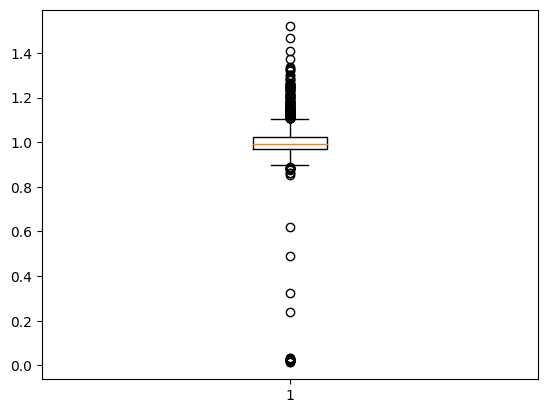

In [11]:
plt.boxplot(S['x_mean_fraction'])

In [12]:
S[S['x_mean_fraction'] < .8]

,study_id,series_id,instance_number,condition,level,x,y,x_mean_fraction
64,38281420,880361156,9,Spinal Canal Stenosis,L5/S1,5.000000,5.000000,0.032722
656,283265383,221289021,10,Spinal Canal Stenosis,L5/S1,71.800000,71.300000,0.620898
661,286903519,1921917205,13,Spinal Canal Stenosis,L5/S1,5.000007,5.000007,0.019846
1475,665627263,2231471633,9,Spinal Canal Stenosis,L1/L2,5.000000,5.000000,0.013212
3217,1438760543,737753815,9,Spinal Canal Stenosis,L1/L2,5.000042,4.999993,0.026057
3379,1510451897,1488857550,9,Spinal Canal Stenosis,L4/L5,5.000000,4.999982,0.034348
4067,1820866003,131094096,7,Spinal Canal Stenosis,L2/L3,5.000000,2.063098,0.022388
4223,1880970480,3736941525,8,Spinal Canal Stenosis,L5/S1,5.000000,5.000000,0.024127
4261,1901348744,1490272456,11,Spinal Canal Stenosis,L3/L4,4.999947,4.999971,0.018048
4384,1973833645,833708507,15,Spinal Canal Stenosis,L1/L2,187.590245,351.529052,0.489658


In [13]:
S.loc[S['x_mean_fraction'] < .8,['x','y']] = torch.nan

In [14]:
S = S[[
    'study_id',
    'series_id',
    'level',
    'x',
    'y'
]].groupby(['study_id','series_id','level']).mean().reset_index()
S.tail()

,study_id,series_id,level,x,y
9748,4290709089,3274612423,L1/L2,181.668947,88.864569
9749,4290709089,3274612423,L2/L3,174.227086,125.198358
9750,4290709089,3274612423,L3/L4,174.227086,160.656635
9751,4290709089,3274612423,L4/L5,182.544460,191.299590
9752,4290709089,3274612423,L5/S1,194.363885,218.878249


In [15]:
centers = {}
for i in range(len(S)):
    row = S.iloc[i]
    centers[row['study_id']]={}
for i in range(len(S)):
    row = S.iloc[i]
    centers[row['study_id']][row['series_id']]={'L1/L2':[], 'L2/L3':[],'L3/L4':[],'L4/L5':[],'L5/S1':[]}
for i in range(len(S)):
    row = S.iloc[i]
    centers[row['study_id']][row['series_id']][row['level']].append([row['x'],row['y']])

In [16]:
coordinates = np.zeros((len(S),10))
coordinates[:] = np.nan
for i in range(len(S)):
    row = S.iloc[i]
    for level in centers[row['study_id']][row['series_id']]:
            if len(centers[row['study_id']][row['series_id']][level]) > 0:
                center = np.array(centers[row['study_id']][row['series_id']][level]).mean(0)
                coordinates[
                    i,
                    {'L1/L2':0, 'L2/L3':2,'L3/L4':4,'L4/L5':6,'L5/S1':8}[level]:{'L1/L2':0, 'L2/L3':2,'L3/L4':4,'L4/L5':6,'L5/S1':8}[level]+2
                ] = center

In [17]:
S = S[[
    'study_id',
    'series_id'   
]]
S[[
    'x_L1L2',
    'y_L1L2',
    'x_L2L3',
    'y_L2L3',
    'x_L3L4',
    'y_L3L4',
    'x_L4L5',
    'y_L4L5',
    'x_L5S1',
    'y_L5S1'
]] = coordinates
S = S.drop_duplicates().reset_index(drop=True)
S.tail()

,study_id,series_id,x_L1L2,y_L1L2,x_L2L3,y_L2L3,x_L3L4,y_L3L4,x_L4L5,y_L4L5,x_L5S1,y_L5S1
1969,4282019580,1547999333,217.588235,104.823529,202.305085,151.864407,196.411765,193.764706,203.470588,241.058824,214.058824,274.235294
1970,4283570761,453728183,252.096578,148.066797,239.788300,209.608186,232.427696,265.899924,235.546307,315.797706,254.013013,364.807609
1971,4284048608,3767301072,290.154631,203.001570,276.591052,269.915228,272.974097,335.020408,280.208006,391.083203,295.580063,443.529042
1972,4287160193,1507070277,391.235190,235.644570,369.435472,321.805360,373.587800,391.356841,397.463681,456.755994,427.568054,516.964739
1973,4290709089,3274612423,181.668947,88.864569,174.227086,125.198358,174.227086,160.656635,182.544460,191.299590,194.363885,218.878249


In [18]:
import math

In [19]:
for i in []:#range(len(S)):
    row = S.iloc[i]
    print(row.values.astype(int))
    sagittal_t2_id = row['series_id']
    centers = torch.as_tensor([x for x in row[[
        'x_L1L2',
        'y_L1L2',
        'x_L2L3',
        'y_L2L3',
        'x_L3L4',
        'y_L3L4',
        'x_L4L5',
        'y_L4L5',
        'x_L5S1',
        'y_L5S1'
    ]]]).view(5,2).float()
        
    sample = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/'
    sample = sample+str(int(row['study_id']))+'/'+str(int(row['series_id']))
    
    images = [x for x in glob.glob(sample+'/*.dcm')]
    images.sort(key = lambda x:int(x.split('/')[-1].replace('.dcm','')))
#   Trust central slices only, cut 2/5 to head and tail
    head = tail = (2*len(images))//5
    images = images[head:-tail]
        
    image = np.stack([pydicom.dcmread(x).pixel_array for x in images])
    D,H,W = image.shape
    centers[:,0] = centers[:,0]*512/W
    centers[:,1] = centers[:,1]*512/H
    image = resize_volume(image,cfg.point_net.image_size)
    x_map = torch.stack([torch.arange(512)]*512).float()
    y_map = torch.stack([torch.arange(512)]*512).T.float()
    idx_map = torch.stack([x_map,y_map]).view(1,2,512,512)
    s2 = torch.as_tensor([512/8]*5)
#   Then the corresponding alphas and normalization constants would be
    A = -1/(2*s2)
    K = 1/torch.sqrt(2*math.pi*s2)
#   Ideal heatmaps
    mask = idx_map - centers.view(5,2,1,1)
    mask = torch.exp((A.view(5,1,1,1)*mask*mask).sum(1))*100
    probability = np.zeros((6,512,512))
    probability[1:] = mask
    img = np.float32(image[len(image)//2])
    p = probability_to_rgb(probability)
    m = cv2.cvtColor(
                    img,
                    cv2.COLOR_GRAY2BGR
    )
    m = 255 - (255 - m * 0.8) * (1 - p / 255)

    plt.imshow(m / 255)
    plt.show()

# Basic flow:
- We use affine transformation for projection of dicom array's 2d points into 3d world corrdinates. See our previous notebook: https://www.kaggle.com/code/hengck23/2d-to-3d-projection-for-dicom

- Given sagittal volume, choose central slice z.
- Use a 2d unet to predict the (x,y) coordinates of the 5 level key points (spinal_canal_stenosis label points)
- Project x,y,z inpto word coordinates xx,yy,zz.
- Now given the axial volume, compute the level (l1_l2, ..., l5_s1) for each slice, using their distances from xx,yy,zz points.



In [20]:
class myUNet(nn.Module):
    def __init__(self):
        super(myUNet, self).__init__()

        self.UNet = smp.Unet(
            encoder_name="resnet18",
            classes=5,
            in_channels=1
        ).to(device)

    def forward(self,X):
        x = self.UNet(X)
#       MinMaxScaling along the class plane to generate a heatmap
        min_values = x.view(-1,5,PATCH_SIZE*PATCH_SIZE).min(-1)[0].view(-1,5,1,1)
        max_values = x.view(-1,5,PATCH_SIZE*PATCH_SIZE).max(-1)[0].view(-1,5,1,1)
        x = (x - min_values)/(max_values - min_values)
        
        return x

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [22]:
model = torch.load('/kaggle/input/sagittal-t2-workflow/Sagittal_T2_segmentation_1',map_location=torch.device(device))

In [23]:
S = S[S.isna().sum(1)==0].reset_index(drop=True)
S.tail()

,study_id,series_id,x_L1L2,y_L1L2,x_L2L3,y_L2L3,x_L3L4,y_L3L4,x_L4L5,y_L4L5,x_L5S1,y_L5S1
1878,4282019580,1547999333,217.588235,104.823529,202.305085,151.864407,196.411765,193.764706,203.470588,241.058824,214.058824,274.235294
1879,4283570761,453728183,252.096578,148.066797,239.788300,209.608186,232.427696,265.899924,235.546307,315.797706,254.013013,364.807609
1880,4284048608,3767301072,290.154631,203.001570,276.591052,269.915228,272.974097,335.020408,280.208006,391.083203,295.580063,443.529042
1881,4287160193,1507070277,391.235190,235.644570,369.435472,321.805360,373.587800,391.356841,397.463681,456.755994,427.568054,516.964739
1882,4290709089,3274612423,181.668947,88.864569,174.227086,125.198358,174.227086,160.656635,182.544460,191.299590,194.363885,218.878249


In [24]:
import tqdm

In [25]:
assignments = {}
for i in tqdm.tqdm(range(len(S))):
    row = S.iloc[i]
    study_id = int(row['study_id'])
    axial_t2_ids    = id_df[(id_df.study_id == int(row['study_id'])) & (id_df.series_description=='Axial T2')].series_id
    sagittal_t2_id = int(row['series_id'])
    for axial_t2_id in axial_t2_ids:
        try:
                sagittal_t2_point = torch.as_tensor([x for x in row[[
                    'x_L1L2',
                    'y_L1L2',
                    'x_L2L3',
                    'y_L2L3',
                    'x_L3L4',
                    'y_L3L4',
                    'x_L4L5',
                    'y_L4L5',
                    'x_L5S1',
                    'y_L5S1'
                ]]]).view(5,2).float()


                data = read_study(study_id, axial_t2_id=axial_t2_id, sagittal_t2_id=sagittal_t2_id)


                #--- step.1 : detect 2d point in sagittal_t2
                sagittal_t2 = data.sagittal_t2.volume
                sagittal_t2_df = data.sagittal_t2.df
                axial_t2_df = data.axial_t2.df

                D,H,W = sagittal_t2.shape
                
                sagittal_t2_point[:,0] = sagittal_t2_point[:,0]*512/W
                sagittal_t2_point[:,1] = sagittal_t2_point[:,1]*512/H
                
                sagittal_t2_z = D//2            

                #for debug and development
                point_hat, z_hat = sagittal_t2_point_hat = get_true_sagittal_t2_point(study_id, sagittal_t2_df)
                point_hat = point_hat*[[cfg.point_net.image_size/W, cfg.point_net.image_size/H]]


                #--- step.2 : perdict slice level of axial_t2
                world_point = view_to_world(sagittal_t2_point, sagittal_t2_z, sagittal_t2_df, cfg.point_net.image_size)
                assigned_level, closest_z, dis  = axial_t2_level = point_to_level(world_point, axial_t2_df)
                
                key = str(study_id)+'_'+str(sagittal_t2_id)+'_'+str(axial_t2_id)
                assignments[key] = {1:{},2:{},3:{},4:{},5:{}}
                for k in range(5):
                    assignments[key][k + 1]['dis'] = dis[k][assigned_level == k + 1]
                    assignments[key][k + 1]['instance_numbers'] = axial_t2_df.instance_number[assigned_level == k + 1].values

                if 0:
                    print('assigned_level:', assigned_level)
                    ###################################################################
                    #visualisation
                    # https://matplotlib.org/stable/gallery/mplot3d/mixed_subplots.html
                    fig = plt.figure(figsize=(23, 6))
                    ax2 = fig.add_subplot(1, 2, 2, projection='3d')

                    # draw  assigned_level
                    level_ncolor = np.array(level_color) / 255
                    coloring = level_ncolor[assigned_level].tolist()
                    draw_slice(
                        ax2, axial_t2_df,
                        is_slice=True,   scolor=coloring, salpha=[0.1],
                        is_border=True,  bcolor=coloring, balpha=[0.2],
                        is_origin=False, ocolor=[[0, 0, 0]], oalpha=[0.0],
                        is_arrow=True
                    )

                    # draw world_point
                    ax2.scatter(world_point[:, 0], world_point[:, 1], world_point[:, 2], alpha=1, color='black')


                    ### draw closest slice
                    coloring = level_ncolor[1:].tolist()
                    draw_slice(
                        ax2, axial_t2_df.iloc[closest_z],
                        is_slice=True, scolor=coloring, salpha=[0.1],
                        is_border=True, bcolor=coloring, balpha=[1],
                        is_origin=False, ocolor=[[1, 0, 0]], oalpha=[0],
                        is_arrow=False
                    )

                    ax2.set_aspect('equal')
                    ax2.set_title(f'axial slice assignment\n series_id:{sagittal_t2_id}')
                    ax2.set_xlabel('x')
                    ax2.set_ylabel('y')
                    ax2.set_zlabel('z')
                    ax2.view_init(elev=0, azim=-10, roll=0)
                    plt.tight_layout(pad=2)
                    plt.show()
        
        except:
            print(study_id,sagittal_t2_id,axial_t2_id)

 76%|███████▌  | 1423/1883 [41:49<17:30,  2.28s/it]

3244012867 3331933042 2235334886


100%|██████████| 1883/1883 [54:39<00:00,  1.74s/it]


In [26]:
import pickle

In [27]:
with open('level_assignments.pkl', 'wb') as f:
    pickle.dump(assignments, f)